In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [3]:
le = LabelEncoder()

## Get training data

In [4]:
df_train = pd.read_csv('all_data_no_duplicates_equal_size.csv', index_col=0)

In [5]:
le.fit(df_train['genre'])
df_train["genre"] = le.transform(df_train['genre'])

In [6]:
integer_mapping = {l: i for i, l in enumerate(le.classes_)}
integer_mapping

{'blues': 0,
 'classical': 1,
 'disco': 2,
 'electronic': 3,
 'hiphop': 4,
 'jazz': 5,
 'pop': 6,
 'rock': 7}

In [7]:
X_train, y_train = df_train.drop(['genre'], axis=1), df_train['genre']

## Get testing data

In [8]:
df_test = pd.read_csv('data_for_stacking.csv', index_col=0)

In [9]:
df_test["genre"] = le.transform(df_test['genre'])

In [10]:
X_test, y_test = df_test.drop(['genre'], axis=1), df_test['genre']

## Training model

In [ ]:
scaler = MinMaxScaler()
pca_25 = PCA(n_components=25)
pca_30 = PCA(n_components=30)

In [ ]:
knn = KNeighborsClassifier(leaf_size=10, n_neighbors=7, p=1)
svm = SVC(C=10, gamma=0.1, kernel='rbf', probability=True)
rf = RandomForestClassifier(max_depth=9, min_samples_leaf=1, n_estimators=150)
lr = LogisticRegression(penalty='l2', max_iter=10000)

In [ ]:
pipe_knn = Pipeline(steps=[('scaler', scaler), ('pca', pca_25), ('knn', knn)])
pipe_svm = Pipeline(steps=[('scaler', scaler), ('pca', pca_30), ('svm', svm)])


In [ ]:
estimators = [('pipe_knn', pipe_knn),
              ('pipe_svm', pipe_svm),
              ('rf', rf)]

In [ ]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=lr)

In [ ]:
grid_params_stacking = {
    'final_estimator__C': np.logspace(-4, 3, 50),
}

In [ ]:
final_stacking_clf = GridSearchCV(estimator=stacking_clf, param_grid=grid_params_stacking, cv=5, verbose=1, scoring='accuracy')

In [ ]:
final_stacking_clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('pipe_knn',
                                                       Pipeline(steps=[('scaler',
                                                                        MinMaxScaler()),
                                                                       ('pca',
                                                                        PCA(n_components=25)),
                                                                       ('knn',
                                                                        KNeighborsClassifier(leaf_size=10,
                                                                                             n_neighbors=7,
                                                                                             p=1))])),
                                                      ('pipe_svm',
                                                       Pipeline(steps=[('scaler',
                       

In [ ]:
final_stacking_clf.best_params_

{'final_estimator__C': 1.389495494373136}

In [ ]:
y_preds_stacking = final_stacking_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_preds_stacking)

0.6682577565632458

In [ ]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_preds_stacking)))

              precision    recall  f1-score   support

       blues       0.41      0.30      0.35        47
   classical       0.68      0.95      0.79        56
       disco       0.53      0.70      0.60        37
  electronic       0.77      0.75      0.76        64
      hiphop       0.69      0.63      0.66        43
        jazz       0.88      0.76      0.81        78
         pop       0.54      0.44      0.48        64
        rock       0.66      0.83      0.74        30

    accuracy                           0.67       419
   macro avg       0.65      0.67      0.65       419
weighted avg       0.67      0.67      0.66       419



In [12]:
import copy
def drop_features(X):
    final_features_drop = ['chroma_std_2', 'beats_std', 'chroma_std_7', 'chroma_std_11', 'beats_a', 'chroma_a_3', 'chroma_a_9', 'rmseH_skew', 'chroma_a_2', 'chroma_a_1', 'chroma_std_3', 'chroma_std_1', 'mfcc_std_1', 'chroma_std_6', 'tonnetz_a', 'chroma_a_10', 'chroma_a_11']
    return X.drop(final_features_drop, axis=1)
feature_selection = FunctionTransformer(drop_features)
X_copy = copy.deepcopy(X_train)
output = feature_selection.transform(X_copy)
len(output.columns)

62

In [13]:
scaler = MinMaxScaler()
pca_25 = PCA(n_components=25)
pca_40 = PCA(n_components=40)

knn = KNeighborsClassifier(leaf_size=28, n_neighbors=20, p=2)
svm = SVC(C=10, gamma=0.1, kernel='rbf', probability=True)
rf = RandomForestClassifier(n_estimators=150, max_depth=12, min_samples_leaf=2, criterion="gini", max_features="sqrt")
lr = LogisticRegression(penalty='l2', max_iter=10000) #l2 since lbfgs solver supports l2 and we don't have outliers

pipe_knn = Pipeline(steps=[('scaler', scaler), ('pca', pca_25), ('knn', knn)])
pipe_svm = Pipeline(steps=[('scaler', scaler), ('pca', pca_40), ('svm', svm)])
pipe_rf = Pipeline(steps=[('feature_selection', feature_selection), ('rf', rf)])

estimators = [('pipe_knn', pipe_knn),
              ('pipe_svm', pipe_svm),
              ('pipe_rf', pipe_rf)]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=lr)

grid_params_stacking = {
    'final_estimator__C': np.logspace(-2, 2, 20),
}

final_stacking_clf = GridSearchCV(estimator=stacking_clf, param_grid=grid_params_stacking, cv=5, verbose=1, scoring='accuracy', return_train_score=True)
final_stacking_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('pipe_knn',
                                                       Pipeline(steps=[('scaler',
                                                                        MinMaxScaler()),
                                                                       ('pca',
                                                                        PCA(n_components=25)),
                                                                       ('knn',
                                                                        KNeighborsClassifier(leaf_size=28,
                                                                                             n_neighbors=20))])),
                                                      ('pipe_svm',
                                                       Pipeline(steps=[('scaler',
                                                                        MinMaxScaler()),
                                                                       ('pca',
                                                                        PCA(n_components=40)),
                                                                       ('svm',
                                                                        SVC(C=10,
                                                                            gamma=0.1,
                                                                            probability=True))])),
                                                      ('pipe_rf',
                                                       Pipel...
             param_grid={'final_estimator__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])},
             return_train_score=True, scoring='accuracy', verbose=1)

In [14]:
final_stacking_clf.best_params_

{'final_estimator__C': 1.2742749857031335}

In [15]:
final_stacking_clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_final_estimator__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [16]:
final_stacking_clf.cv_results_['mean_test_score']

array([0.71477273, 0.71590909, 0.71818182, 0.72272727, 0.72045455,
       0.71704545, 0.72045455, 0.71704545, 0.71931818, 0.73068182,
       0.73409091, 0.72840909, 0.72386364, 0.72386364, 0.73181818,
       0.71363636, 0.72045455, 0.72840909, 0.72386364, 0.71818182])

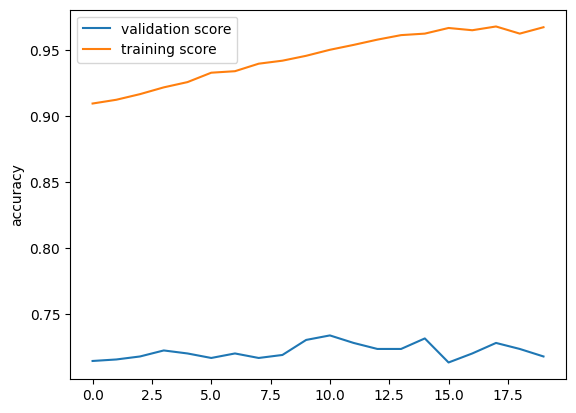

In [17]:
test_scores = final_stacking_clf.cv_results_['mean_test_score']
train_scores = final_stacking_clf.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='validation score')
plt.plot(train_scores, label='training score')
plt.legend(loc='best')
plt.ylabel("accuracy")
plt.show()

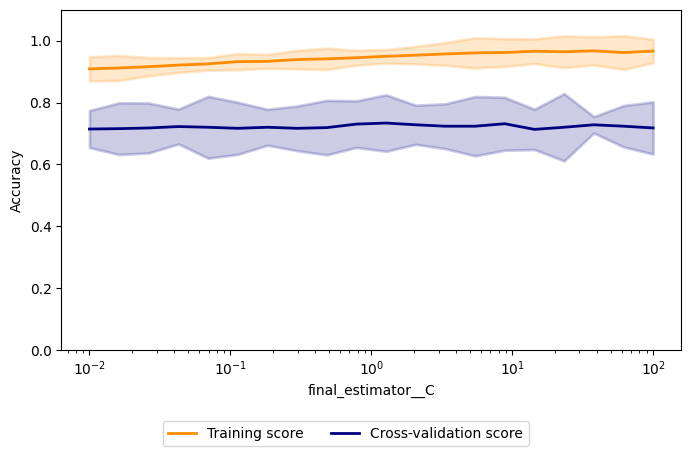

In [18]:
import pandas as pd
df = pd.DataFrame(final_stacking_clf.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = 5
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


fig, axes = plt.subplots(1, len(grid_params_stacking), 
                         figsize = (8*len(grid_params_stacking), 5),
                         sharey='row')
axes.set_ylabel("Accuracy")
lw = 2

for idx, (param_name, param_range) in enumerate(grid_params_stacking.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df.groupby(f'param_{param_name}')[results]
    axes.set_xlabel(param_name)
    axes.set_ylim(0.0, 1.1)
    axes.plot(param_range, 
                grouped_df['mean_train_score'],
                label="Training score",
                color="darkorange",
                lw=lw)
    axes.fill_between(param_range,
                grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                grouped_df['mean_train_score'] + grouped_df['std_train_score'],
                alpha=0.2,
                color="darkorange",
                lw=lw)
    axes.plot(param_range,
                grouped_df['mean_test_score'],
                label="Cross-validation score",
                color="navy",
                lw=lw)
    axes.fill_between(param_range,
                    grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'],
                    alpha=0.2,
                    color="navy",
                    lw=lw)

handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc=8, ncol=2, fontsize=10)
axes.set_xscale('log')
fig.subplots_adjust(bottom=0.2)  
plt.show()

In [22]:
y_preds_stacking2 = final_stacking_clf.predict(X_test)
accuracy_score(y_test, y_preds_stacking2)

0.6875

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds_stacking2))

              precision    recall  f1-score   support

           0       0.45      0.30      0.36        30
           1       0.68      0.90      0.77        30
           2       0.66      0.77      0.71        30
           3       0.72      0.77      0.74        30
           4       0.90      0.63      0.75        30
           5       0.75      0.80      0.77        30
           6       0.54      0.50      0.52        30
           7       0.78      0.83      0.81        30

    accuracy                           0.69       240
   macro avg       0.68      0.69      0.68       240
weighted avg       0.68      0.69      0.68       240



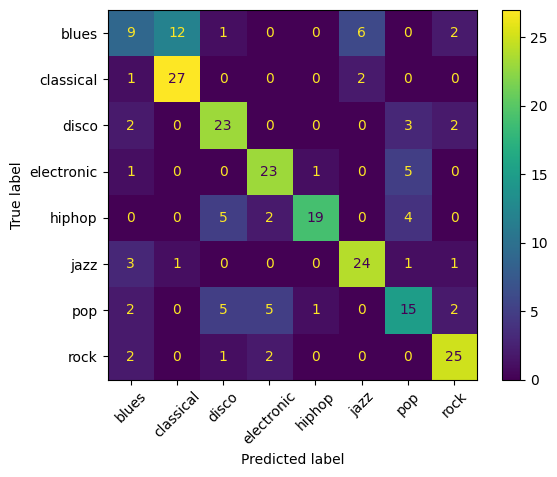

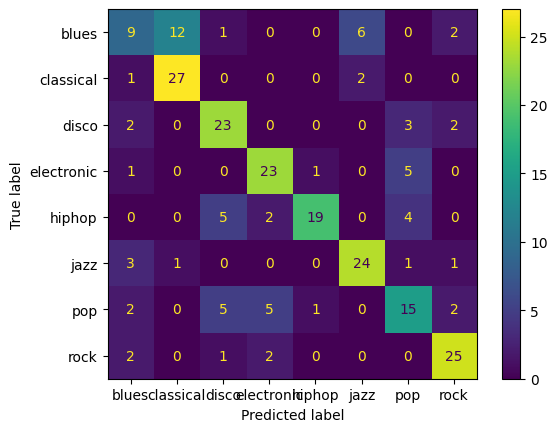

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#conf_mat = confusion_matrix(y_test, y_preds_stacking2)
ConfusionMatrixDisplay.from_estimator(final_stacking_clf, X_test, y_test, display_labels=le.classes_, xticks_rotation=45).plot()

## Majority Voting Classifier

In [25]:
voting_clr = VotingClassifier(estimators=estimators, voting='soft')

In [26]:
voting_clr.fit(X_train, y_train)

VotingClassifier(estimators=[('pipe_knn',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('pca', PCA(n_components=25)),
                                              ('knn',
                                               KNeighborsClassifier(leaf_size=28,
                                                                    n_neighbors=20))])),
                             ('pipe_svm',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('pca', PCA(n_components=40)),
                                              ('svm',
                                               SVC(C=10, gamma=0.1,
                                                   probability=True))])),
                             ('pipe_rf',
                              Pipeline(steps=[('feature_selection',
                                               FunctionTransformer(func=<function drop_features at 0x7f503910c8b0>)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=12,
                                                                      min_samples_leaf=2,
                                                                      n_estimators=150))]))],
                 voting='soft')

In [27]:
preds_voting = voting_clr.predict(X_test)

In [28]:

accuracy_score(y_test, preds_voting)

0.6833333333333333

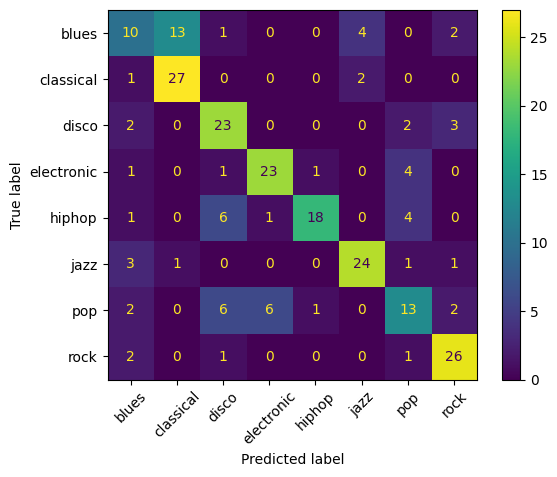

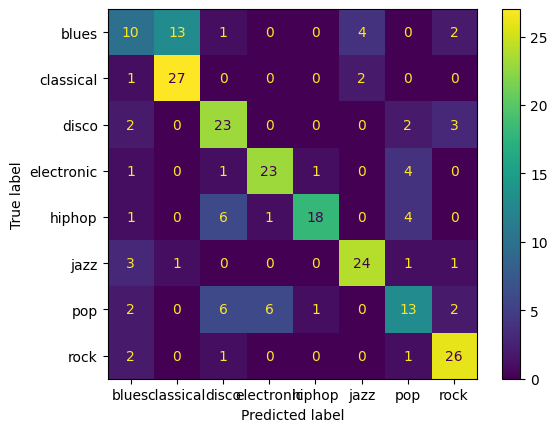

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(voting_clr, X_test, y_test, display_labels=le.classes_, xticks_rotation=45).plot()